### Get data from the database 
- emissions by sectors data by joining two tables
    - Save the data in a csv file for visualization
- ghg emissions data by joining two tables
    - Clean the raw data
    - Save the data in a csv file for visualization

#### Fetch emissions by sectors data from the database

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
import psycopg2
from config import db_password

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# create database connection
user = "postgres"
password = db_password
host = "emissions-db.cr5mfnfivfxl.us-east-1.rds.amazonaws.com"
port = '5432'
database = "GHG_emissions"

conn_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'
        
# Create an instance of database engine        
engine = create_engine(conn_string)

# SQL query to send to database
country_sectors_emissions_list = 'select c.country_name, e."year", e.sector_name ,e.emissions from sector_emissions as e\
                                  join country as c\
                                  on e.country_code = c.country_code;'

# Read the database results into Pandas dataframe
emissions_by_sectors_df = pd.read_sql_query(country_sectors_emissions_list, engine);
emissions_by_sectors_df.shape

(40509, 4)

In [4]:
#Display dataframe
emissions_by_sectors_df

,country_name,year,sector_name,emissions
0,Zimbabwe,2017,bunker_fuels,0.52
1,Zimbabwe,2016,bunker_fuels,0.52
2,Zimbabwe,2015,bunker_fuels,0.54
3,Zimbabwe,2014,bunker_fuels,0.54
4,Zimbabwe,2013,bunker_fuels,0.58
...,...,...,...,...
40504,Afghanistan,1994,transportation,0.71
40505,Afghanistan,1993,transportation,0.74
40506,Afghanistan,1992,transportation,0.77
40507,Afghanistan,1991,transportation,1.55


In [5]:
#Save data into csv file
emissions_by_sectors_df.to_csv('../Resources/emissions_by_sectors_viz.csv',index= False)

#### Get ghg emissions data from the database
- Clean the data
- save the data in a csv for visualization 


In [6]:
# SQL query to send to database
ghg_emissions_list = 'select c.country_name, e.* from ghg_emissions as e join country as c\
                      on e.country_code = c.country_code;'

# Read the database results into Pandas dataframe
ghg_emissions_df = pd.read_sql_query(ghg_emissions_list, engine);

In [7]:
#Display the data
ghg_emissions_df

,country_name,country_code,year,forest_area_in_per,cereal_yield,electricity_access_percent,renewable_energy_consumption,fossil_energy_use,energy_use_per_capita,emissions_total,...,methane_emissions(kt_CO2_emissions),nitrous_oxide_emissions(mt_CO2_emissions),gdp_per_capita,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,pop_total,urban_pop_total,urban_pop_percent
0,Zimbabwe,ZWE,2016,45.570273,435.100000,42.561729,81.900000,NaN,NaN,11020.000458,...,11869.999886,4980.0,1421.787789,42.517883,54.314703,3.167414,2.081806,14452704.0,4667645.0,32.296000
1,Zimbabwe,ZWE,2015,45.689363,557.500000,33.700001,80.820000,NaN,NaN,12430.000305,...,12260.000229,5400.0,1410.329174,42.872671,54.029704,3.097626,2.136294,14154937.0,4584076.0,32.385000
2,Zimbabwe,ZWE,2014,45.808453,831.400000,32.299999,80.270000,NaN,NaN,12079.999924,...,11369.999886,4910.0,1407.034293,43.172363,53.799451,3.028186,2.191391,13855753.0,4503674.0,32.504000
3,Zimbabwe,ZWE,2013,45.927543,668.500000,40.498375,78.870000,29.095759,832.572236,12279.999733,...,12340.000153,5500.0,1408.367810,43.370440,53.634994,2.994566,2.163267,13555422.0,4426387.0,32.654000
4,Zimbabwe,ZWE,2012,46.046633,695.700000,44.000000,77.500000,28.860873,814.910235,12010.000229,...,12460.000038,5800.0,1290.193956,43.453948,53.556956,2.989096,1.822309,13265331.0,4355539.0,32.834000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7177,Africa Eastern and Southern,AFE,1994,35.624993,1374.695849,NaN,65.379764,48.811618,743.131843,312160.000000,...,339339.997625,194000.0,697.183018,45.568530,51.544417,2.887053,2.619955,344418362.0,92816300.0,26.948709
7178,Africa Eastern and Southern,AFE,1993,35.776246,1427.680683,NaN,65.291676,49.280685,742.813558,303600.000000,...,330319.996810,191220.0,704.742868,45.643524,51.460703,2.895773,2.658526,335625136.0,88973631.0,26.509823
7179,Africa Eastern and Southern,AFE,1992,35.927499,949.672903,NaN,64.636541,47.966507,732.667501,295090.000000,...,326880.001700,191600.0,728.765774,45.607528,51.492668,2.899804,2.633682,326933522.0,85244233.0,26.073874
7180,Africa Eastern and Southern,AFE,1991,36.078752,1364.936487,NaN,62.876319,50.493553,773.326417,298735.435602,...,321170.003211,189120.0,858.297836,45.580850,51.518647,2.900503,2.792410,318544083.0,81691094.0,25.645146


In [8]:
# Function to get count of empty cells per row in a column
def retrieve_missing_count(filter_column, df_to_filter):
    
    # Create a dictionary with unique values in a filter_column as keys
    unique_column_values = dict.fromkeys(df_to_filter[filter_column].unique(), 0)
    
    # Iterate over rows in dataframe as (index, Series) pairs.
    for index, row in df_to_filter.iterrows():
        # For each row, get the empty cell count and add it as value for unique_column_value key
        unique_column_values[row[filter_column]] += row.isnull().sum()
    
    # Sort the column by missing values in ascending order
    missing_count_sorted = dict(sorted(unique_column_values.items(), key=lambda item: item[1]))
    
    # return the dictionary with column values (as keys) and missing count (as values)
    return missing_count_sorted

In [9]:
# Create a df to filter by missing values of countries
filter_countries_df = ghg_emissions_df.copy()
filter_countries_df.shape

(7182, 22)

In [10]:
# Retrieve count of empty cells per year
missing_country_dict = retrieve_missing_count('country_code',filter_countries_df)
for country, val in missing_country_dict.items():
    print(country, ":", val)

USA : 2
GBR : 2
CHE : 2
SWE : 2
ESP : 2
PRT : 2
POL : 2
NOR : 2
NLD : 2
KOR : 2
JPN : 2
ITA : 2
IRL : 2
GRC : 2
DEU : 2
FRA : 2
FIN : 2
DNK : 2
CHL : 2
AUT : 2
AUS : 2
NZL : 3
PST : 3
OED : 3
NAC : 3
HIC : 3
EUU : 3
EMU : 3
SAU : 4
ROU : 4
PAN : 4
NGA : 4
MEX : 4
MUS : 4
JOR : 4
JAM : 4
HUN : 4
CYP : 4
COL : 4
BGR : 4
BRA : 4
ARG : 4
ALB : 4
IDN : 5
HND : 5
SLV : 5
DOM : 5
CMR : 5
BWA : 5
BGD : 5
ZMB : 6
URY : 6
TZA : 6
PER : 6
MAR : 6
EGY : 6
BOL : 6
TLA : 6
LAC : 6
LCN : 6
TEC : 6
ECS : 6
CEB : 6
ARE : 7
SEN : 7
PHL : 7
NIC : 7
KEN : 7
IND : 7
GHA : 7
EAR : 7
ZWE : 8
UKR : 8
TUN : 8
RUS : 8
MKD : 8
MLT : 8
CZE : 8
CIV : 8
BLR : 8
TSA : 8
SAS : 8
LMC : 8
AFW : 8
PRY : 9
HTI : 9
GTM : 9
ECU : 9
CAN : 9
ZAF : 10
SVK : 10
NPL : 10
BEN : 10
ECA : 10
YEM : 11
OMN : 11
TSS : 11
SSA : 11
SSF : 11
ARB : 11
TUR : 12
TGO : 12
PAK : 12
NAM : 12
MOZ : 12
KWT : 12
ISR : 12
BEL : 12
WLD : 12
PRE : 12
VNM : 13
KAZ : 13
IDA : 13
IDX : 13
IDB : 13
TTO : 14
THA : 14
LKA : 14
MMR : 14
MNG : 14
MYS : 14


In [11]:
# Set missing country limit
# Removing rows for countries with more than limit.
missing_limit_country = 250

In [12]:
# Filter rows
# This we need to do for both ML and visualization hence keeping filtering countries data as a common step here

print(f"Number of missing values in the dataset before filtering the countries: {filter_countries_df.isnull().sum().sum()}")
print(f"Number of rows before filtering the countries: {filter_countries_df.shape[0]}")

# filter only rows for countries within specified limit
countries_filter = []
for key, val in missing_country_dict.items():
    if val<missing_limit_country:
        countries_filter.append(key)

filter_countries_df = filter_countries_df[filter_countries_df['country_code'].isin(countries_filter)]

print(f"Number of missing values in the dataset after filtering the countries: {filter_countries_df.isnull().sum().sum()}")
print(f"Number of rows after filtering the countries:{filter_countries_df.shape[0]}")

Number of missing values in the dataset before filtering the countries: 12818
Number of rows before filtering the countries: 7182
Number of missing values in the dataset after filtering the countries: 10594
Number of rows after filtering the countries:6993


In [13]:
#Drop rows which has missing values for the column energy_use_per_capita
filter_countries_df = filter_countries_df.dropna(subset =['energy_use_per_capita','electricity_access_percent'])
filter_countries_df.shape  

(4049, 22)

In [14]:
# A dataframe to hold filtered values
emissions_df = filter_countries_df.copy()
emissions_df.shape

(4049, 22)

In [15]:
# Check for duplicates
emissions_df.duplicated().sum()

0

<Figure size 1000x600 with 0 Axes>

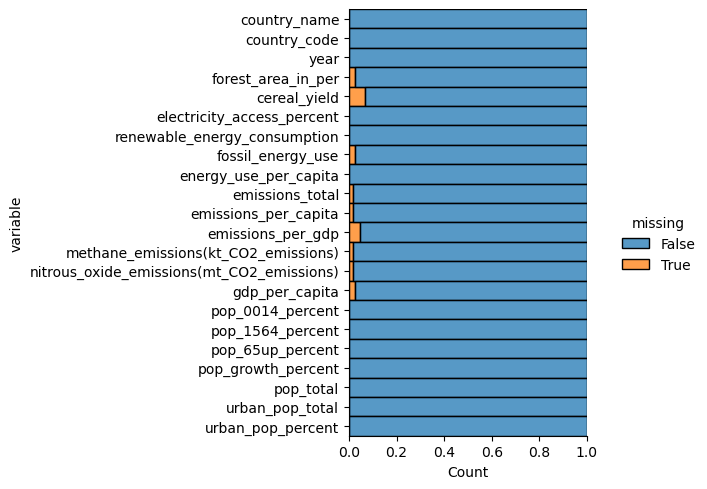

In [16]:
# Compute the proportion of the missing data for each variable in the data and make stacked barplot. 
plt.figure(figsize=(10,6))
sns.displot(
    data=emissions_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [17]:
emissions_df.isnull().sum()

country_name                                   0
country_code                                   0
year                                           0
forest_area_in_per                           109
cereal_yield                                 270
electricity_access_percent                     0
renewable_energy_consumption                   1
fossil_energy_use                            109
energy_use_per_capita                          0
emissions_total                               76
emissions_per_capita                          76
emissions_per_gdp                            192
methane_emissions(kt_CO2_emissions)           75
nitrous_oxide_emissions(mt_CO2_emissions)     76
gdp_per_capita                               101
pop_0014_percent                               0
pop_1564_percent                               0
pop_65up_percent                               0
pop_growth_percent                             1
pop_total                                      0
urban_pop_total     

In [18]:
# Retrieve count of empty cells per year
missing_year_dict = retrieve_missing_count('year',emissions_df)
for key, value in missing_year_dict.items():
    print(key, ":", value)
    

2015 : 0
2014 : 31
2011 : 32
2008 : 32
2013 : 33
2009 : 33
2003 : 33
2001 : 35
2000 : 35
1998 : 35
1997 : 35
1995 : 35
2002 : 36
1999 : 36
1996 : 36
2012 : 37
2010 : 38
2007 : 39
2004 : 43
2006 : 44
2005 : 47
1994 : 55
1993 : 57
1992 : 59
1991 : 90
1990 : 100


In [19]:
# Filter the missing values per year 
print(f"Number of missing values in dataset before filtering the years: {emissions_df.isnull().sum().sum()}")
print(f"Number of rows before filtering the years: {emissions_df.shape[0]}")

# Filter rows for year bins
filter_year = emissions_df['year'] > 1990
emissions_df = emissions_df[filter_year]

print(f"Number of missing values in the dataset after filtering the years: {emissions_df.isnull().sum().sum()}")
print(f"Number of rows after filtering the years: {emissions_df.shape[0]}")

Number of missing values in dataset before filtering the years: 1086
Number of rows before filtering the years: 4049
Number of missing values in the dataset after filtering the years: 986
Number of rows after filtering the years: 3966


In [20]:
emissions_df.isnull().sum()

country_name                                   0
country_code                                   0
year                                           0
forest_area_in_per                            87
cereal_yield                                 246
electricity_access_percent                     0
renewable_energy_consumption                   0
fossil_energy_use                            103
energy_use_per_capita                          0
emissions_total                               72
emissions_per_capita                          72
emissions_per_gdp                            173
methane_emissions(kt_CO2_emissions)           72
nitrous_oxide_emissions(mt_CO2_emissions)     72
gdp_per_capita                                88
pop_0014_percent                               0
pop_1564_percent                               0
pop_65up_percent                               0
pop_growth_percent                             1
pop_total                                      0
urban_pop_total     

In [21]:
#Filling zero for remaining missing values as to make use of other available data for other columns for visualization.
emissions_df = emissions_df.fillna(0)
emissions_df

,country_name,country_code,year,forest_area_in_per,cereal_yield,electricity_access_percent,renewable_energy_consumption,fossil_energy_use,energy_use_per_capita,emissions_total,...,methane_emissions(kt_CO2_emissions),nitrous_oxide_emissions(mt_CO2_emissions),gdp_per_capita,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,pop_total,urban_pop_total,urban_pop_percent
3,Zimbabwe,ZWE,2013,45.927543,668.500000,40.498375,78.870000,29.095759,832.572236,12279.999733,...,12340.000153,5500.0,1408.367810,43.370440,53.634994,2.994566,2.163267,13555422.0,4426387.0,32.654000
4,Zimbabwe,ZWE,2012,46.046633,695.700000,44.000000,77.500000,28.860873,814.910235,12010.000229,...,12460.000038,5800.0,1290.193956,43.453948,53.556956,2.989096,1.822309,13265331.0,4355539.0,32.834000
5,Zimbabwe,ZWE,2011,46.165723,587.400000,36.900002,79.270000,28.492743,787.030033,11409.999847,...,12640.000343,6260.0,1082.615774,43.383758,53.647926,2.968316,1.438339,13025785.0,4300463.0,33.015000
6,Zimbabwe,ZWE,2010,46.284813,733.400000,38.782551,82.270000,24.855705,736.691254,9600.000381,...,12270.000458,6120.0,937.840338,43.170055,53.889596,2.940349,1.253650,12839771.0,4262290.0,33.196000
7,Zimbabwe,ZWE,2009,46.403903,452.400000,43.369083,82.090000,23.930831,720.587138,7750.000000,...,11829.999924,5770.0,762.297957,42.912761,54.169175,2.918064,1.026265,12679810.0,4232267.0,33.378000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,Africa Eastern and Southern,AFE,2004,33.654274,1394.049728,23.815880,63.279292,48.862058,751.434195,457599.991269,...,425989.999363,223010.0,985.530235,44.085558,53.053032,2.861411,2.644968,445281555.0,133647466.0,30.014148
7168,Africa Eastern and Southern,AFE,2003,34.177441,1296.064498,22.548307,64.165735,47.271779,733.782234,426379.996829,...,416979.997346,220890.0,812.946404,44.258112,52.881280,2.860609,2.617764,433807484.0,128833965.0,29.698419
7169,Africa Eastern and Southern,AFE,2002,34.357452,1453.381135,21.601503,64.622779,46.195218,720.036948,404210.007127,...,403830.003740,216190.0,626.559857,44.444558,52.695278,2.860163,2.606598,422741118.0,124227507.0,29.386190
7170,Africa Eastern and Southern,AFE,2001,34.537463,1442.820237,19.986220,65.586773,47.435746,732.364434,393150.000000,...,382970.000686,202400.0,628.204191,44.646159,52.495289,2.858552,2.589961,412001885.0,119775502.0,29.071591


In [22]:
#Check for null
emissions_df.isnull().sum()

country_name                                 0
country_code                                 0
year                                         0
forest_area_in_per                           0
cereal_yield                                 0
electricity_access_percent                   0
renewable_energy_consumption                 0
fossil_energy_use                            0
energy_use_per_capita                        0
emissions_total                              0
emissions_per_capita                         0
emissions_per_gdp                            0
methane_emissions(kt_CO2_emissions)          0
nitrous_oxide_emissions(mt_CO2_emissions)    0
gdp_per_capita                               0
pop_0014_percent                             0
pop_1564_percent                             0
pop_65up_percent                             0
pop_growth_percent                           0
pop_total                                    0
urban_pop_total                              0
urban_pop_per

In [23]:
#Save data into csv file
emissions_df.to_csv('../Resources/ghg_emissions_viz.csv',index= False)